In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [2]:
my_output = None

In [3]:
from diffusers.schedulers.scheduling_dpmsolver_multistep import *

class DPMSolverMultistepScheduler(SchedulerMixin, ConfigMixin):
    """
    `DPMSolverMultistepScheduler` is a fast dedicated high-order solver for diffusion ODEs.

    This model inherits from [`SchedulerMixin`] and [`ConfigMixin`]. Check the superclass documentation for the generic
    methods the library implements for all schedulers such as loading and saving.

    Args:
        num_train_timesteps (`int`, defaults to 1000):
            The number of diffusion steps to train the model.
        beta_start (`float`, defaults to 0.0001):
            The starting `beta` value of inference.
        beta_end (`float`, defaults to 0.02):
            The final `beta` value.
        beta_schedule (`str`, defaults to `"linear"`):
            The beta schedule, a mapping from a beta range to a sequence of betas for stepping the model. Choose from
            `linear`, `scaled_linear`, or `squaredcos_cap_v2`.
        trained_betas (`np.ndarray`, *optional*):
            Pass an array of betas directly to the constructor to bypass `beta_start` and `beta_end`.
        solver_order (`int`, defaults to 2):
            The DPMSolver order which can be `1` or `2` or `3`. It is recommended to use `solver_order=2` for guided
            sampling, and `solver_order=3` for unconditional sampling.
        prediction_type (`str`, defaults to `epsilon`, *optional*):
            Prediction type of the scheduler function; can be `epsilon` (predicts the noise of the diffusion process),
            `sample` (directly predicts the noisy sample`) or `v_prediction` (see section 2.4 of [Imagen
            Video](https://imagen.research.google/video/paper.pdf) paper).
        thresholding (`bool`, defaults to `False`):
            Whether to use the "dynamic thresholding" method. This is unsuitable for latent-space diffusion models such
            as Stable Diffusion.
        dynamic_thresholding_ratio (`float`, defaults to 0.995):
            The ratio for the dynamic thresholding method. Valid only when `thresholding=True`.
        sample_max_value (`float`, defaults to 1.0):
            The threshold value for dynamic thresholding. Valid only when `thresholding=True` and
            `algorithm_type="dpmsolver++"`.
        algorithm_type (`str`, defaults to `dpmsolver++`):
            Algorithm type for the solver; can be `dpmsolver`, `dpmsolver++`, `sde-dpmsolver` or `sde-dpmsolver++`. The
            `dpmsolver` type implements the algorithms in the [DPMSolver](https://huggingface.co/papers/2206.00927)
            paper, and the `dpmsolver++` type implements the algorithms in the
            [DPMSolver++](https://huggingface.co/papers/2211.01095) paper. It is recommended to use `dpmsolver++` or
            `sde-dpmsolver++` with `solver_order=2` for guided sampling like in Stable Diffusion.
        solver_type (`str`, defaults to `midpoint`):
            Solver type for the second-order solver; can be `midpoint` or `heun`. The solver type slightly affects the
            sample quality, especially for a small number of steps. It is recommended to use `midpoint` solvers.
        lower_order_final (`bool`, defaults to `True`):
            Whether to use lower-order solvers in the final steps. Only valid for < 15 inference steps. This can
            stabilize the sampling of DPMSolver for steps < 15, especially for steps <= 10.
        euler_at_final (`bool`, defaults to `False`):
            Whether to use Euler's method in the final step. It is a trade-off between numerical stability and detail
            richness. This can stabilize the sampling of the SDE variant of DPMSolver for small number of inference
            steps, but sometimes may result in blurring.
        use_karras_sigmas (`bool`, *optional*, defaults to `False`):
            Whether to use Karras sigmas for step sizes in the noise schedule during the sampling process. If `True`,
            the sigmas are determined according to a sequence of noise levels {σi}.
        use_lu_lambdas (`bool`, *optional*, defaults to `False`):
            Whether to use the uniform-logSNR for step sizes proposed by Lu's DPM-Solver in the noise schedule during
            the sampling process. If `True`, the sigmas and time steps are determined according to a sequence of
            `lambda(t)`.
        final_sigmas_type (`str`, defaults to `"zero"`):
            The final `sigma` value for the noise schedule during the sampling process. If `"sigma_min"`, the final sigma
            is the same as the last sigma in the training schedule. If `zero`, the final sigma is set to 0.
        lambda_min_clipped (`float`, defaults to `-inf`):
            Clipping threshold for the minimum value of `lambda(t)` for numerical stability. This is critical for the
            cosine (`squaredcos_cap_v2`) noise schedule.
        variance_type (`str`, *optional*):
            Set to "learned" or "learned_range" for diffusion models that predict variance. If set, the model's output
            contains the predicted Gaussian variance.
        timestep_spacing (`str`, defaults to `"linspace"`):
            The way the timesteps should be scaled. Refer to Table 2 of the [Common Diffusion Noise Schedules and
            Sample Steps are Flawed](https://huggingface.co/papers/2305.08891) for more information.
        steps_offset (`int`, defaults to 0):
            An offset added to the inference steps. You can use a combination of `offset=1` and
            `set_alpha_to_one=False` to make the last step use step 0 for the previous alpha product like in Stable
            Diffusion.
    """

    _compatibles = [e.name for e in KarrasDiffusionSchedulers]
    order = 1

    @register_to_config
    def __init__(
        self,
        num_train_timesteps: int = 1000,
        beta_start: float = 0.0001,
        beta_end: float = 0.02,
        beta_schedule: str = "linear",
        trained_betas: Optional[Union[np.ndarray, List[float]]] = None,
        solver_order: int = 2,
        prediction_type: str = "epsilon",
        thresholding: bool = False,
        dynamic_thresholding_ratio: float = 0.995,
        sample_max_value: float = 1.0,
        algorithm_type: str = "dpmsolver++",
        solver_type: str = "midpoint",
        lower_order_final: bool = True,
        euler_at_final: bool = False,
        use_karras_sigmas: Optional[bool] = False,
        use_lu_lambdas: Optional[bool] = False,
        final_sigmas_type: Optional[str] = "zero",  # "zero", "sigma_min"
        lambda_min_clipped: float = -float("inf"),
        variance_type: Optional[str] = None,
        timestep_spacing: str = "linspace",
        steps_offset: int = 0,
        backprob_repaint: bool = False,
    ):  
        if algorithm_type in ["dpmsolver", "sde-dpmsolver"]:
            deprecation_message = f"algorithm_type {algorithm_type} is deprecated and will be removed in a future version. Choose from `dpmsolver++` or `sde-dpmsolver++` instead"
            deprecate("algorithm_types dpmsolver and sde-dpmsolver", "1.0.0", deprecation_message)

        if trained_betas is not None:
            self.betas = torch.tensor(trained_betas, dtype=torch.float32)
        elif beta_schedule == "linear":
            self.betas = torch.linspace(beta_start, beta_end, num_train_timesteps, dtype=torch.float32)
        elif beta_schedule == "scaled_linear":
            # this schedule is very specific to the latent diffusion model.
            self.betas = torch.linspace(beta_start**0.5, beta_end**0.5, num_train_timesteps, dtype=torch.float32) ** 2
        elif beta_schedule == "squaredcos_cap_v2":
            # Glide cosine schedule
            self.betas = betas_for_alpha_bar(num_train_timesteps)
        else:
            raise NotImplementedError(f"{beta_schedule} does is not implemented for {self.__class__}")

        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        # Currently we only support VP-type noise schedule
        self.alpha_t = torch.sqrt(self.alphas_cumprod)
        self.sigma_t = torch.sqrt(1 - self.alphas_cumprod)
        self.lambda_t = torch.log(self.alpha_t) - torch.log(self.sigma_t)
        self.sigmas = ((1 - self.alphas_cumprod) / self.alphas_cumprod) ** 0.5

        # standard deviation of the initial noise distribution
        self.init_noise_sigma = 1.0

        # settings for DPM-Solver
        if algorithm_type not in ["dpmsolver", "dpmsolver++", "sde-dpmsolver", "sde-dpmsolver++"]:
            if algorithm_type == "deis":
                self.register_to_config(algorithm_type="dpmsolver++")
            else:
                raise NotImplementedError(f"{algorithm_type} does is not implemented for {self.__class__}")

        if solver_type not in ["midpoint", "heun"]:
            if solver_type in ["logrho", "bh1", "bh2"]:
                self.register_to_config(solver_type="midpoint")
            else:
                raise NotImplementedError(f"{solver_type} does is not implemented for {self.__class__}")

        if algorithm_type not in ["dpmsolver++", "sde-dpmsolver++"] and final_sigmas_type == "zero":
            raise ValueError(
                f"`final_sigmas_type` {final_sigmas_type} is not supported for `algorithm_type` {algorithm_type}. Please choose `sigma_min` instead."
            )

        # setable values
        self.num_inference_steps = None
        timesteps = np.linspace(0, num_train_timesteps - 1, num_train_timesteps, dtype=np.float32)[::-1].copy()
        self.timesteps = torch.from_numpy(timesteps)
        self.model_outputs = [None] * solver_order
        self.lower_order_nums = 0
        self._step_index = None
        self.sigmas = self.sigmas.to("cpu")  # to avoid too much CPU/GPU communication

    @property
    def step_index(self):
        """
        The index counter for current timestep. It will increae 1 after each scheduler step.
        """
        return self._step_index

    def set_timesteps(self, num_inference_steps: int = None, device: Union[str, torch.device] = None):
        """
        Sets the discrete timesteps used for the diffusion chain (to be run before inference).

        Args:
            num_inference_steps (`int`):
                The number of diffusion steps used when generating samples with a pre-trained model.
            device (`str` or `torch.device`, *optional*):
                The device to which the timesteps should be moved to. If `None`, the timesteps are not moved.
        """
        # Clipping the minimum of all lambda(t) for numerical stability.
        # This is critical for cosine (squaredcos_cap_v2) noise schedule.
        clipped_idx = torch.searchsorted(torch.flip(self.lambda_t, [0]), self.config.lambda_min_clipped)
        last_timestep = ((self.config.num_train_timesteps - clipped_idx).numpy()).item()

        # "linspace", "leading", "trailing" corresponds to annotation of Table 2. of https://arxiv.org/abs/2305.08891
        if self.config.timestep_spacing == "linspace":
            timesteps = (
                np.linspace(0, last_timestep - 1, num_inference_steps + 1).round()[::-1][:-1].copy().astype(np.int64)
            )
        elif self.config.timestep_spacing == "leading":
            step_ratio = last_timestep // (num_inference_steps + 1)
            # creates integer timesteps by multiplying by ratio
            # casting to int to avoid issues when num_inference_step is power of 3
            timesteps = (np.arange(0, num_inference_steps + 1) * step_ratio).round()[::-1][:-1].copy().astype(np.int64)
            timesteps += self.config.steps_offset
        elif self.config.timestep_spacing == "trailing":
            step_ratio = self.config.num_train_timesteps / num_inference_steps
            # creates integer timesteps by multiplying by ratio
            # casting to int to avoid issues when num_inference_step is power of 3
            timesteps = np.arange(last_timestep, 0, -step_ratio).round().copy().astype(np.int64)
            timesteps -= 1
        else:
            raise ValueError(
                f"{self.config.timestep_spacing} is not supported. Please make sure to choose one of 'linspace', 'leading' or 'trailing'."
            )

        sigmas = np.array(((1 - self.alphas_cumprod) / self.alphas_cumprod) ** 0.5)
        log_sigmas = np.log(sigmas)

        if self.config.use_karras_sigmas:
            sigmas = np.flip(sigmas).copy()
            sigmas = self._convert_to_karras(in_sigmas=sigmas, num_inference_steps=num_inference_steps)
            timesteps = np.array([self._sigma_to_t(sigma, log_sigmas) for sigma in sigmas]).round()
        elif self.config.use_lu_lambdas:
            lambdas = np.flip(log_sigmas.copy())
            lambdas = self._convert_to_lu(in_lambdas=lambdas, num_inference_steps=num_inference_steps)
            sigmas = np.exp(lambdas)
            timesteps = np.array([self._sigma_to_t(sigma, log_sigmas) for sigma in sigmas]).round()
        else:
            sigmas = np.interp(timesteps, np.arange(0, len(sigmas)), sigmas)

        if self.config.final_sigmas_type == "sigma_min":
            sigma_last = ((1 - self.alphas_cumprod[0]) / self.alphas_cumprod[0]) ** 0.5
        elif self.config.final_sigmas_type == "zero":
            sigma_last = 0
        else:
            raise ValueError(
                f"`final_sigmas_type` must be one of 'zero', or 'sigma_min', but got {self.config.final_sigmas_type}"
            )

        sigmas = np.concatenate([sigmas, [sigma_last]]).astype(np.float32)

        self.sigmas = torch.from_numpy(sigmas)
        self.timesteps = torch.from_numpy(timesteps).to(device=device, dtype=torch.int64)

        self.num_inference_steps = len(timesteps)

        self.model_outputs = [
            None,
        ] * self.config.solver_order
        self.lower_order_nums = 0

        # add an index counter for schedulers that allow duplicated timesteps
        self._step_index = None
        self.sigmas = self.sigmas.to("cpu")  # to avoid too much CPU/GPU communication

    # Copied from diffusers.schedulers.scheduling_ddpm.DDPMScheduler._threshold_sample
    def _threshold_sample(self, sample: torch.FloatTensor) -> torch.FloatTensor:
        """
        "Dynamic thresholding: At each sampling step we set s to a certain percentile absolute pixel value in xt0 (the
        prediction of x_0 at timestep t), and if s > 1, then we threshold xt0 to the range [-s, s] and then divide by
        s. Dynamic thresholding pushes saturated pixels (those near -1 and 1) inwards, thereby actively preventing
        pixels from saturation at each step. We find that dynamic thresholding results in significantly better
        photorealism as well as better image-text alignment, especially when using very large guidance weights."

        https://arxiv.org/abs/2205.11487
        """
        dtype = sample.dtype
        batch_size, channels, *remaining_dims = sample.shape

        if dtype not in (torch.float32, torch.float64):
            sample = sample.float()  # upcast for quantile calculation, and clamp not implemented for cpu half

        # Flatten sample for doing quantile calculation along each image
        sample = sample.reshape(batch_size, channels * np.prod(remaining_dims))

        abs_sample = sample.abs()  # "a certain percentile absolute pixel value"

        s = torch.quantile(abs_sample, self.config.dynamic_thresholding_ratio, dim=1)
        s = torch.clamp(
            s, min=1, max=self.config.sample_max_value
        )  # When clamped to min=1, equivalent to standard clipping to [-1, 1]
        s = s.unsqueeze(1)  # (batch_size, 1) because clamp will broadcast along dim=0
        sample = torch.clamp(sample, -s, s) / s  # "we threshold xt0 to the range [-s, s] and then divide by s"

        sample = sample.reshape(batch_size, channels, *remaining_dims)
        sample = sample.to(dtype)

        return sample

    # Copied from diffusers.schedulers.scheduling_euler_discrete.EulerDiscreteScheduler._sigma_to_t
    def _sigma_to_t(self, sigma, log_sigmas):
        # get log sigma
        log_sigma = np.log(np.maximum(sigma, 1e-10))

        # get distribution
        dists = log_sigma - log_sigmas[:, np.newaxis]

        # get sigmas range
        low_idx = np.cumsum((dists >= 0), axis=0).argmax(axis=0).clip(max=log_sigmas.shape[0] - 2)
        high_idx = low_idx + 1

        low = log_sigmas[low_idx]
        high = log_sigmas[high_idx]

        # interpolate sigmas
        w = (low - log_sigma) / (low - high)
        w = np.clip(w, 0, 1)

        # transform interpolation to time range
        t = (1 - w) * low_idx + w * high_idx
        t = t.reshape(sigma.shape)
        return t

    def _sigma_to_alpha_sigma_t(self, sigma):
        alpha_t = 1 / ((sigma**2 + 1) ** 0.5)
        sigma_t = sigma * alpha_t

        return alpha_t, sigma_t

    # Copied from diffusers.schedulers.scheduling_euler_discrete.EulerDiscreteScheduler._convert_to_karras
    def _convert_to_karras(self, in_sigmas: torch.FloatTensor, num_inference_steps) -> torch.FloatTensor:
        """Constructs the noise schedule of Karras et al. (2022)."""

        # Hack to make sure that other schedulers which copy this function don't break
        # TODO: Add this logic to the other schedulers
        if hasattr(self.config, "sigma_min"):
            sigma_min = self.config.sigma_min
        else:
            sigma_min = None

        if hasattr(self.config, "sigma_max"):
            sigma_max = self.config.sigma_max
        else:
            sigma_max = None

        sigma_min = sigma_min if sigma_min is not None else in_sigmas[-1].item()
        sigma_max = sigma_max if sigma_max is not None else in_sigmas[0].item()

        rho = 7.0  # 7.0 is the value used in the paper
        ramp = np.linspace(0, 1, num_inference_steps)
        min_inv_rho = sigma_min ** (1 / rho)
        max_inv_rho = sigma_max ** (1 / rho)
        sigmas = (max_inv_rho + ramp * (min_inv_rho - max_inv_rho)) ** rho
        return sigmas

    def _convert_to_lu(self, in_lambdas: torch.FloatTensor, num_inference_steps) -> torch.FloatTensor:
        """Constructs the noise schedule of Lu et al. (2022)."""

        lambda_min: float = in_lambdas[-1].item()
        lambda_max: float = in_lambdas[0].item()

        rho = 1.0  # 1.0 is the value used in the paper
        ramp = np.linspace(0, 1, num_inference_steps)
        min_inv_rho = lambda_min ** (1 / rho)
        max_inv_rho = lambda_max ** (1 / rho)
        lambdas = (max_inv_rho + ramp * (min_inv_rho - max_inv_rho)) ** rho
        return lambdas

    def convert_model_output(
        self,
        model_output: torch.FloatTensor,
        *args,
        sample: torch.FloatTensor = None,
        **kwargs,
    ) -> torch.FloatTensor:
        """
        Convert the model output to the corresponding type the DPMSolver/DPMSolver++ algorithm needs. DPM-Solver is
        designed to discretize an integral of the noise prediction model, and DPM-Solver++ is designed to discretize an
        integral of the data prediction model.

        <Tip>

        The algorithm and model type are decoupled. You can use either DPMSolver or DPMSolver++ for both noise
        prediction and data prediction models.

        </Tip>

        Args:
            model_output (`torch.FloatTensor`):
                The direct output from the learned diffusion model.
            sample (`torch.FloatTensor`):
                A current instance of a sample created by the diffusion process.

        Returns:
            `torch.FloatTensor`:
                The converted model output.
        """
        timestep = args[0] if len(args) > 0 else kwargs.pop("timestep", None)
        if sample is None:
            if len(args) > 1:
                sample = args[1]
            else:
                raise ValueError("missing `sample` as a required keyward argument")
        if timestep is not None:
            deprecate(
                "timesteps",
                "1.0.0",
                "Passing `timesteps` is deprecated and has no effect as model output conversion is now handled via an internal counter `self.step_index`",
            )

        # DPM-Solver++ needs to solve an integral of the data prediction model.
        if self.config.algorithm_type in ["dpmsolver++", "sde-dpmsolver++"]:
            if self.config.prediction_type == "epsilon":
                # DPM-Solver and DPM-Solver++ only need the "mean" output.
                if self.config.variance_type in ["learned", "learned_range"]:
                    model_output = model_output[:, :3]
                sigma = self.sigmas[self.step_index]
                alpha_t, sigma_t = self._sigma_to_alpha_sigma_t(sigma)
                x0_pred = (sample - sigma_t * model_output) / alpha_t
            elif self.config.prediction_type == "sample":
                x0_pred = model_output
            elif self.config.prediction_type == "v_prediction":
                sigma = self.sigmas[self.step_index]
                alpha_t, sigma_t = self._sigma_to_alpha_sigma_t(sigma)
                x0_pred = alpha_t * sample - sigma_t * model_output
            else:
                raise ValueError(
                    f"prediction_type given as {self.config.prediction_type} must be one of `epsilon`, `sample`, or"
                    " `v_prediction` for the DPMSolverMultistepScheduler."
                )

            if self.config.thresholding:
                x0_pred = self._threshold_sample(x0_pred)
            
            if self.config.backprob_repaint:
                x0_pred = self._backprob_inpaint(x0_pred)

            return x0_pred

        # DPM-Solver needs to solve an integral of the noise prediction model.
        elif self.config.algorithm_type in ["dpmsolver", "sde-dpmsolver"]:
            if self.config.prediction_type == "epsilon":
                # DPM-Solver and DPM-Solver++ only need the "mean" output.
                if self.config.variance_type in ["learned", "learned_range"]:
                    epsilon = model_output[:, :3]
                else:
                    epsilon = model_output
            elif self.config.prediction_type == "sample":
                sigma = self.sigmas[self.step_index]
                alpha_t, sigma_t = self._sigma_to_alpha_sigma_t(sigma)
                epsilon = (sample - alpha_t * model_output) / sigma_t
            elif self.config.prediction_type == "v_prediction":
                sigma = self.sigmas[self.step_index]
                alpha_t, sigma_t = self._sigma_to_alpha_sigma_t(sigma)
                epsilon = alpha_t * model_output + sigma_t * sample
            else:
                raise ValueError(
                    f"prediction_type given as {self.config.prediction_type} must be one of `epsilon`, `sample`, or"
                    " `v_prediction` for the DPMSolverMultistepScheduler."
                )

            if self.config.thresholding:
                sigma = self.sigmas[self.step_index]
                alpha_t, sigma_t = self._sigma_to_alpha_sigma_t(sigma)
                x0_pred = (sample - sigma_t * epsilon) / alpha_t
                x0_pred = self._threshold_sample(x0_pred)
                epsilon = (sample - alpha_t * x0_pred) / sigma_t

            return epsilon

    def dpm_solver_first_order_update(
        self,
        model_output: torch.FloatTensor,
        *args,
        sample: torch.FloatTensor = None,
        noise: Optional[torch.FloatTensor] = None,
        **kwargs,
    ) -> torch.FloatTensor:
        """
        One step for the first-order DPMSolver (equivalent to DDIM).

        Args:
            model_output (`torch.FloatTensor`):
                The direct output from the learned diffusion model.
            sample (`torch.FloatTensor`):
                A current instance of a sample created by the diffusion process.

        Returns:
            `torch.FloatTensor`:
                The sample tensor at the previous timestep.
        """
        timestep = args[0] if len(args) > 0 else kwargs.pop("timestep", None)
        prev_timestep = args[1] if len(args) > 1 else kwargs.pop("prev_timestep", None)
        if sample is None:
            if len(args) > 2:
                sample = args[2]
            else:
                raise ValueError(" missing `sample` as a required keyward argument")
        if timestep is not None:
            deprecate(
                "timesteps",
                "1.0.0",
                "Passing `timesteps` is deprecated and has no effect as model output conversion is now handled via an internal counter `self.step_index`",
            )

        if prev_timestep is not None:
            deprecate(
                "prev_timestep",
                "1.0.0",
                "Passing `prev_timestep` is deprecated and has no effect as model output conversion is now handled via an internal counter `self.step_index`",
            )

        sigma_t, sigma_s = self.sigmas[self.step_index + 1], self.sigmas[self.step_index]
        alpha_t, sigma_t = self._sigma_to_alpha_sigma_t(sigma_t)
        alpha_s, sigma_s = self._sigma_to_alpha_sigma_t(sigma_s)
        lambda_t = torch.log(alpha_t) - torch.log(sigma_t)
        lambda_s = torch.log(alpha_s) - torch.log(sigma_s)

        h = lambda_t - lambda_s
        if self.config.algorithm_type == "dpmsolver++":
            x_t = (sigma_t / sigma_s) * sample - (alpha_t * (torch.exp(-h) - 1.0)) * model_output
        elif self.config.algorithm_type == "dpmsolver":
            x_t = (alpha_t / alpha_s) * sample - (sigma_t * (torch.exp(h) - 1.0)) * model_output
        elif self.config.algorithm_type == "sde-dpmsolver++":
            assert noise is not None
            x_t = (
                (sigma_t / sigma_s * torch.exp(-h)) * sample
                + (alpha_t * (1 - torch.exp(-2.0 * h))) * model_output
                + sigma_t * torch.sqrt(1.0 - torch.exp(-2 * h)) * noise
            )
        elif self.config.algorithm_type == "sde-dpmsolver":
            assert noise is not None
            x_t = (
                (alpha_t / alpha_s) * sample
                - 2.0 * (sigma_t * (torch.exp(h) - 1.0)) * model_output
                + sigma_t * torch.sqrt(torch.exp(2 * h) - 1.0) * noise
            )
        return x_t

    def multistep_dpm_solver_second_order_update(
        self,
        model_output_list: List[torch.FloatTensor],
        *args,
        sample: torch.FloatTensor = None,
        noise: Optional[torch.FloatTensor] = None,
        **kwargs,
    ) -> torch.FloatTensor:
        """
        One step for the second-order multistep DPMSolver.

        Args:
            model_output_list (`List[torch.FloatTensor]`):
                The direct outputs from learned diffusion model at current and latter timesteps.
            sample (`torch.FloatTensor`):
                A current instance of a sample created by the diffusion process.

        Returns:
            `torch.FloatTensor`:
                The sample tensor at the previous timestep.
        """
        timestep_list = args[0] if len(args) > 0 else kwargs.pop("timestep_list", None)
        prev_timestep = args[1] if len(args) > 1 else kwargs.pop("prev_timestep", None)
        if sample is None:
            if len(args) > 2:
                sample = args[2]
            else:
                raise ValueError(" missing `sample` as a required keyward argument")
        if timestep_list is not None:
            deprecate(
                "timestep_list",
                "1.0.0",
                "Passing `timestep_list` is deprecated and has no effect as model output conversion is now handled via an internal counter `self.step_index`",
            )

        if prev_timestep is not None:
            deprecate(
                "prev_timestep",
                "1.0.0",
                "Passing `prev_timestep` is deprecated and has no effect as model output conversion is now handled via an internal counter `self.step_index`",
            )

        sigma_t, sigma_s0, sigma_s1 = (
            self.sigmas[self.step_index + 1],
            self.sigmas[self.step_index],
            self.sigmas[self.step_index - 1],
        )

        alpha_t, sigma_t = self._sigma_to_alpha_sigma_t(sigma_t)
        alpha_s0, sigma_s0 = self._sigma_to_alpha_sigma_t(sigma_s0)
        alpha_s1, sigma_s1 = self._sigma_to_alpha_sigma_t(sigma_s1)

        lambda_t = torch.log(alpha_t) - torch.log(sigma_t)
        lambda_s0 = torch.log(alpha_s0) - torch.log(sigma_s0)
        lambda_s1 = torch.log(alpha_s1) - torch.log(sigma_s1)

        m0, m1 = model_output_list[-1], model_output_list[-2]

        h, h_0 = lambda_t - lambda_s0, lambda_s0 - lambda_s1
        r0 = h_0 / h
        D0, D1 = m0, (1.0 / r0) * (m0 - m1)
        if self.config.algorithm_type == "dpmsolver++":
            # See https://arxiv.org/abs/2211.01095 for detailed derivations
            if self.config.solver_type == "midpoint":
                x_t = (
                    (sigma_t / sigma_s0) * sample
                    - (alpha_t * (torch.exp(-h) - 1.0)) * D0
                    - 0.5 * (alpha_t * (torch.exp(-h) - 1.0)) * D1
                )
            elif self.config.solver_type == "heun":
                x_t = (
                    (sigma_t / sigma_s0) * sample
                    - (alpha_t * (torch.exp(-h) - 1.0)) * D0
                    + (alpha_t * ((torch.exp(-h) - 1.0) / h + 1.0)) * D1
                )
        elif self.config.algorithm_type == "dpmsolver":
            # See https://arxiv.org/abs/2206.00927 for detailed derivations
            if self.config.solver_type == "midpoint":
                x_t = (
                    (alpha_t / alpha_s0) * sample
                    - (sigma_t * (torch.exp(h) - 1.0)) * D0
                    - 0.5 * (sigma_t * (torch.exp(h) - 1.0)) * D1
                )
            elif self.config.solver_type == "heun":
                x_t = (
                    (alpha_t / alpha_s0) * sample
                    - (sigma_t * (torch.exp(h) - 1.0)) * D0
                    - (sigma_t * ((torch.exp(h) - 1.0) / h - 1.0)) * D1
                )
        elif self.config.algorithm_type == "sde-dpmsolver++":
            assert noise is not None
            if self.config.solver_type == "midpoint":
                x_t = (
                    (sigma_t / sigma_s0 * torch.exp(-h)) * sample
                    + (alpha_t * (1 - torch.exp(-2.0 * h))) * D0
                    + 0.5 * (alpha_t * (1 - torch.exp(-2.0 * h))) * D1
                    + sigma_t * torch.sqrt(1.0 - torch.exp(-2 * h)) * noise
                )
            elif self.config.solver_type == "heun":
                x_t = (
                    (sigma_t / sigma_s0 * torch.exp(-h)) * sample
                    + (alpha_t * (1 - torch.exp(-2.0 * h))) * D0
                    + (alpha_t * ((1.0 - torch.exp(-2.0 * h)) / (-2.0 * h) + 1.0)) * D1
                    + sigma_t * torch.sqrt(1.0 - torch.exp(-2 * h)) * noise
                )
        elif self.config.algorithm_type == "sde-dpmsolver":
            assert noise is not None
            if self.config.solver_type == "midpoint":
                x_t = (
                    (alpha_t / alpha_s0) * sample
                    - 2.0 * (sigma_t * (torch.exp(h) - 1.0)) * D0
                    - (sigma_t * (torch.exp(h) - 1.0)) * D1
                    + sigma_t * torch.sqrt(torch.exp(2 * h) - 1.0) * noise
                )
            elif self.config.solver_type == "heun":
                x_t = (
                    (alpha_t / alpha_s0) * sample
                    - 2.0 * (sigma_t * (torch.exp(h) - 1.0)) * D0
                    - 2.0 * (sigma_t * ((torch.exp(h) - 1.0) / h - 1.0)) * D1
                    + sigma_t * torch.sqrt(torch.exp(2 * h) - 1.0) * noise
                )
        return x_t

    def multistep_dpm_solver_third_order_update(
        self,
        model_output_list: List[torch.FloatTensor],
        *args,
        sample: torch.FloatTensor = None,
        **kwargs,
    ) -> torch.FloatTensor:
        """
        One step for the third-order multistep DPMSolver.

        Args:
            model_output_list (`List[torch.FloatTensor]`):
                The direct outputs from learned diffusion model at current and latter timesteps.
            sample (`torch.FloatTensor`):
                A current instance of a sample created by diffusion process.

        Returns:
            `torch.FloatTensor`:
                The sample tensor at the previous timestep.
        """

        timestep_list = args[0] if len(args) > 0 else kwargs.pop("timestep_list", None)
        prev_timestep = args[1] if len(args) > 1 else kwargs.pop("prev_timestep", None)
        if sample is None:
            if len(args) > 2:
                sample = args[2]
            else:
                raise ValueError(" missing`sample` as a required keyward argument")
        if timestep_list is not None:
            deprecate(
                "timestep_list",
                "1.0.0",
                "Passing `timestep_list` is deprecated and has no effect as model output conversion is now handled via an internal counter `self.step_index`",
            )

        if prev_timestep is not None:
            deprecate(
                "prev_timestep",
                "1.0.0",
                "Passing `prev_timestep` is deprecated and has no effect as model output conversion is now handled via an internal counter `self.step_index`",
            )

        sigma_t, sigma_s0, sigma_s1, sigma_s2 = (
            self.sigmas[self.step_index + 1],
            self.sigmas[self.step_index],
            self.sigmas[self.step_index - 1],
            self.sigmas[self.step_index - 2],
        )

        alpha_t, sigma_t = self._sigma_to_alpha_sigma_t(sigma_t)
        alpha_s0, sigma_s0 = self._sigma_to_alpha_sigma_t(sigma_s0)
        alpha_s1, sigma_s1 = self._sigma_to_alpha_sigma_t(sigma_s1)
        alpha_s2, sigma_s2 = self._sigma_to_alpha_sigma_t(sigma_s2)

        lambda_t = torch.log(alpha_t) - torch.log(sigma_t)
        lambda_s0 = torch.log(alpha_s0) - torch.log(sigma_s0)
        lambda_s1 = torch.log(alpha_s1) - torch.log(sigma_s1)
        lambda_s2 = torch.log(alpha_s2) - torch.log(sigma_s2)

        m0, m1, m2 = model_output_list[-1], model_output_list[-2], model_output_list[-3]

        h, h_0, h_1 = lambda_t - lambda_s0, lambda_s0 - lambda_s1, lambda_s1 - lambda_s2
        r0, r1 = h_0 / h, h_1 / h
        D0 = m0
        D1_0, D1_1 = (1.0 / r0) * (m0 - m1), (1.0 / r1) * (m1 - m2)
        D1 = D1_0 + (r0 / (r0 + r1)) * (D1_0 - D1_1)
        D2 = (1.0 / (r0 + r1)) * (D1_0 - D1_1)
        if self.config.algorithm_type == "dpmsolver++":
            # See https://arxiv.org/abs/2206.00927 for detailed derivations
            x_t = (
                (sigma_t / sigma_s0) * sample
                - (alpha_t * (torch.exp(-h) - 1.0)) * D0
                + (alpha_t * ((torch.exp(-h) - 1.0) / h + 1.0)) * D1
                - (alpha_t * ((torch.exp(-h) - 1.0 + h) / h**2 - 0.5)) * D2
            )
        elif self.config.algorithm_type == "dpmsolver":
            # See https://arxiv.org/abs/2206.00927 for detailed derivations
            x_t = (
                (alpha_t / alpha_s0) * sample
                - (sigma_t * (torch.exp(h) - 1.0)) * D0
                - (sigma_t * ((torch.exp(h) - 1.0) / h - 1.0)) * D1
                - (sigma_t * ((torch.exp(h) - 1.0 - h) / h**2 - 0.5)) * D2
            )
        return x_t

    def _init_step_index(self, timestep):
        if isinstance(timestep, torch.Tensor):
            timestep = timestep.to(self.timesteps.device)

        index_candidates = (self.timesteps == timestep).nonzero()

        if len(index_candidates) == 0:
            step_index = len(self.timesteps) - 1
        # The sigma index that is taken for the **very** first `step`
        # is always the second index (or the last index if there is only 1)
        # This way we can ensure we don't accidentally skip a sigma in
        # case we start in the middle of the denoising schedule (e.g. for image-to-image)
        elif len(index_candidates) > 1:
            step_index = index_candidates[1].item()
        else:
            step_index = index_candidates[0].item()

        self._step_index = step_index

    def step(
        self,
        model_output: torch.FloatTensor,
        timestep: int,
        sample: torch.FloatTensor,
        generator=None,
        return_dict: bool = True,
    ) -> Union[SchedulerOutput, Tuple]:
        """
        Predict the sample from the previous timestep by reversing the SDE. This function propagates the sample with
        the multistep DPMSolver.

        Args:
            model_output (`torch.FloatTensor`):
                The direct output from learned diffusion model.
            timestep (`int`):
                The current discrete timestep in the diffusion chain.
            sample (`torch.FloatTensor`):
                A current instance of a sample created by the diffusion process.
            generator (`torch.Generator`, *optional*):
                A random number generator.
            return_dict (`bool`):
                Whether or not to return a [`~schedulers.scheduling_utils.SchedulerOutput`] or `tuple`.

        Returns:
            [`~schedulers.scheduling_utils.SchedulerOutput`] or `tuple`:
                If return_dict is `True`, [`~schedulers.scheduling_utils.SchedulerOutput`] is returned, otherwise a
                tuple is returned where the first element is the sample tensor.

        """
        if self.num_inference_steps is None:
            raise ValueError(
                "Number of inference steps is 'None', you need to run 'set_timesteps' after creating the scheduler"
            )

        if self.step_index is None:
            self._init_step_index(timestep)

        # Improve numerical stability for small number of steps
        lower_order_final = (self.step_index == len(self.timesteps) - 1) and (
            self.config.euler_at_final
            or (self.config.lower_order_final and len(self.timesteps) < 15)
            or self.config.final_sigmas_type == "zero"
        )
        lower_order_second = (
            (self.step_index == len(self.timesteps) - 2) and self.config.lower_order_final and len(self.timesteps) < 15
        )

        model_output = self.convert_model_output(model_output, sample=sample)
        for i in range(self.config.solver_order - 1):
            self.model_outputs[i] = self.model_outputs[i + 1]
        self.model_outputs[-1] = model_output

        if self.config.algorithm_type in ["sde-dpmsolver", "sde-dpmsolver++"]:
            noise = randn_tensor(
                model_output.shape, generator=generator, device=model_output.device, dtype=model_output.dtype
            )
        else:
            noise = None

        if self.config.solver_order == 1 or self.lower_order_nums < 1 or lower_order_final:
            prev_sample = self.dpm_solver_first_order_update(model_output, sample=sample, noise=noise)
        elif self.config.solver_order == 2 or self.lower_order_nums < 2 or lower_order_second:
            prev_sample = self.multistep_dpm_solver_second_order_update(self.model_outputs, sample=sample, noise=noise)
        else:
            prev_sample = self.multistep_dpm_solver_third_order_update(self.model_outputs, sample=sample)

        if self.lower_order_nums < self.config.solver_order:
            self.lower_order_nums += 1

        # upon completion increase step index by one
        self._step_index += 1
        global my_output
        my_output = prev_sample

        if not return_dict:
            return (prev_sample,)
        
        return SchedulerOutput(prev_sample=prev_sample)

    def scale_model_input(self, sample: torch.FloatTensor, *args, **kwargs) -> torch.FloatTensor:
        """
        Ensures interchangeability with schedulers that need to scale the denoising model input depending on the
        current timestep.

        Args:
            sample (`torch.FloatTensor`):
                The input sample.

        Returns:
            `torch.FloatTensor`:
                A scaled input sample.
        """
        return sample

    def add_noise(
        self,
        original_samples: torch.FloatTensor,
        noise: torch.FloatTensor,
        timesteps: torch.IntTensor,
    ) -> torch.FloatTensor:
        # Make sure sigmas and timesteps have the same device and dtype as original_samples
        sigmas = self.sigmas.to(device=original_samples.device, dtype=original_samples.dtype)
        if original_samples.device.type == "mps" and torch.is_floating_point(timesteps):
            # mps does not support float64
            schedule_timesteps = self.timesteps.to(original_samples.device, dtype=torch.float32)
            timesteps = timesteps.to(original_samples.device, dtype=torch.float32)
        else:
            schedule_timesteps = self.timesteps.to(original_samples.device)
            timesteps = timesteps.to(original_samples.device)

        step_indices = []
        for timestep in timesteps:
            index_candidates = (schedule_timesteps == timestep).nonzero()
            if len(index_candidates) == 0:
                step_index = len(schedule_timesteps) - 1
            elif len(index_candidates) > 1:
                step_index = index_candidates[1].item()
            else:
                step_index = index_candidates[0].item()
            step_indices.append(step_index)

        sigma = sigmas[step_indices].flatten()
        while len(sigma.shape) < len(original_samples.shape):
            sigma = sigma.unsqueeze(-1)

        alpha_t, sigma_t = self._sigma_to_alpha_sigma_t(sigma)
        noisy_samples = alpha_t * original_samples + sigma_t * noise
        return noisy_samples

    def __len__(self):
        return self.config.num_train_timesteps

    def _backprob_inpaint(self, x0_pred):
        if hasattr(self, 'vae') and hasattr(self, 'mask'):
            lr = 1e-2
            num_iter = 10
            
            for i in range(num_iter):
                x0_pred.requires_grad = True

                with torch.enable_grad():
                    scaled_latent = 1 / self.vae.config.scaling_factor * x0_pred
                    image = self.vae.decode(scaled_latent, return_dict=False)[0]
                
                    loss = (image - self.mask)[self.mask != 0].abs().sum()
                    grads = torch.autograd.grad(outputs=loss, inputs=x0_pred)[0]
                x0_pred = x0_pred - lr * grads
        
        return x0_pred
    
    def add_vae(self, vae):
        vae.requires_grad = True
        self.vae = vae
        
    def add_mask(self, mask):
        mask.requires_grad = True
        self.mask = mask


## Vanilla Generation

In [4]:
import torch
from diffusers import StableDiffusionPipeline 
# DPMSolverMultistepScheduler

model_id = "stabilityai/stable-diffusion-2-1"

# Use the DPMSolverMultistepScheduler (DPM-Solver++) scheduler here instead
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float32)

config = {
    "beta_start": 0.00085,
    "trained_betas": None,
    "prediction_type": "v_prediction",
    "beta_schedule": "scaled_linear",
    "steps_offset": 1,
    "beta_end": 0.012,
    "num_train_timesteps": 1000,
    "thresholding": True,
    "backprob_repaint": True
}
pipe.scheduler = DPMSolverMultistepScheduler(**config)
pipe.scheduler.add_vae(pipe.vae)
# pipe.scheduler.add_mask(None)

pipe = pipe.to("cuda")


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

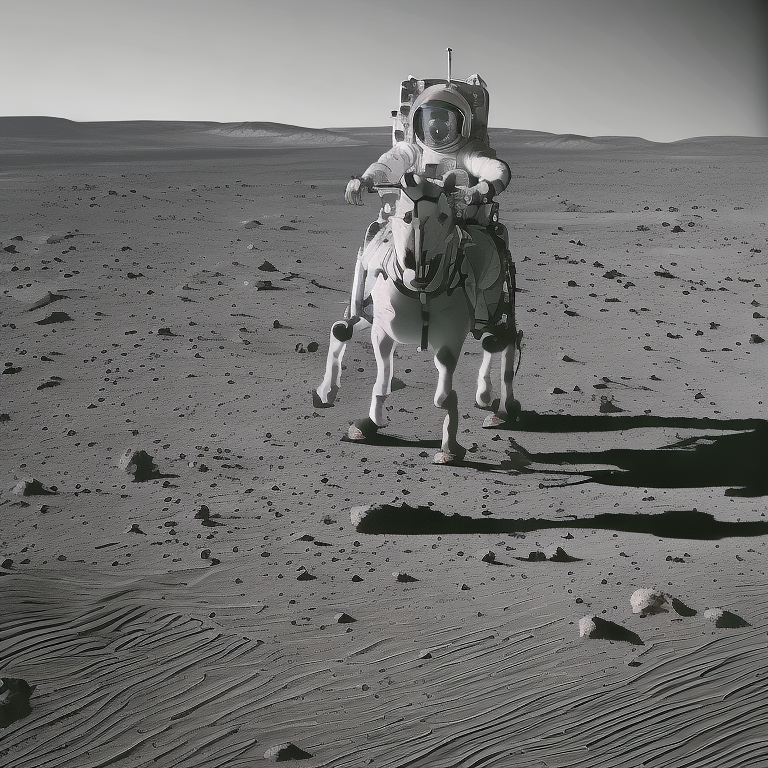

In [5]:
prompt = "extremly high quality photo of an astronaut riding a horse on mars"
output = pipe(prompt)
image = output.images[0]
image

1111  "tensor[1, 3, 768, 768] n=1769472 (6.8Mb) x∈[0., 1.000] μ=0.447 σ=0.167 cuda:0"


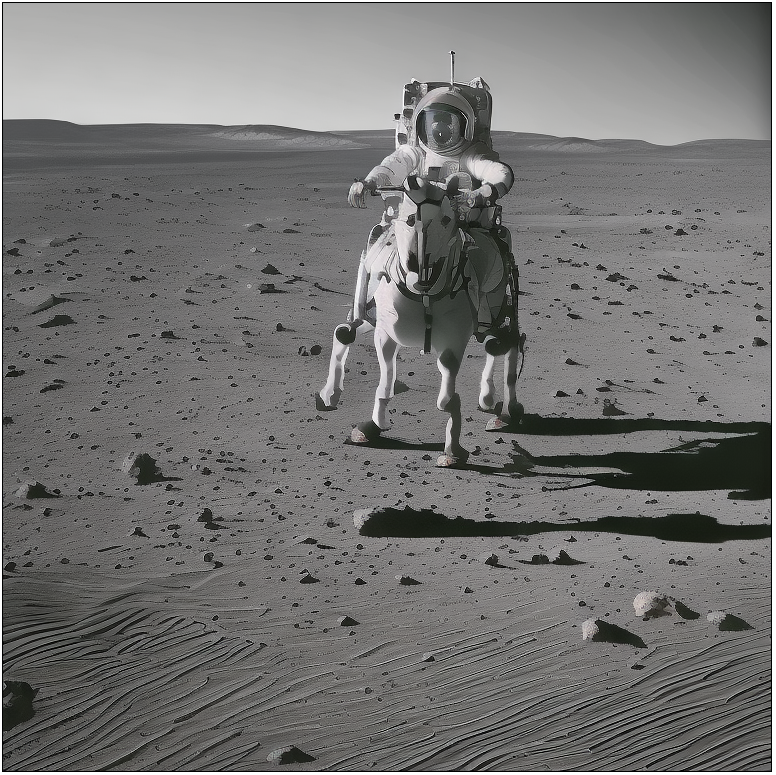

In [6]:
with torch.no_grad():
    latents = 1 / pipe.vae.config.scaling_factor * my_output.detach()
    my_img = pipe.vae.decode(latents, return_dict=False)[0]
    my_img_rescaled = (my_img / 2 + 0.5).clamp(0, 1)
    
import jhutil; jhutil.jhprint(1111, my_img_rescaled)
my_img_rescaled.rgb

## Masked Generation

In [7]:
import torch

def generate_random_coordinates(n, h, w):
    y_coords = torch.randint(0, h, (n,))
    x_coords = torch.randint(0, w, (n,))
    coords = torch.stack((x_coords, y_coords), dim=1)

    return coords

def mask_image_except_coordinates(image, coordinates):
    mask = torch.zeros_like(image)
    mask[:, :, coordinates[:, 1], coordinates[:, 0]] = 1
    masked_image = image * mask

    return masked_image.detach()


coord = generate_random_coordinates(10000, *my_img.shape[2:])
masked_image = mask_image_except_coordinates(my_img, coord)

  0%|          | 0/50 [00:00<?, ?it/s]

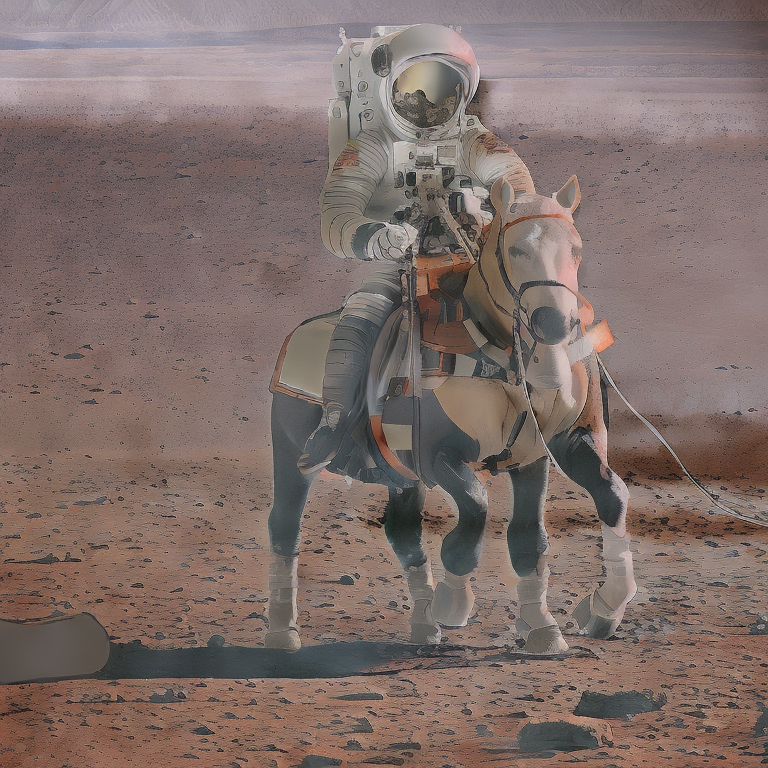

In [8]:
pipe.scheduler.add_mask(masked_image)
pipe.scheduler.add_vae(pipe.vae)

prompt = "extremly high quality photo of an astronaut riding a horse on mars"
output = pipe(prompt)
image = output.images[0]
image

1111  "tensor[1, 3, 768, 768] n=1769472 (6.8Mb) x∈[0., 0.965] μ=0.451 σ=0.127 cuda:0"


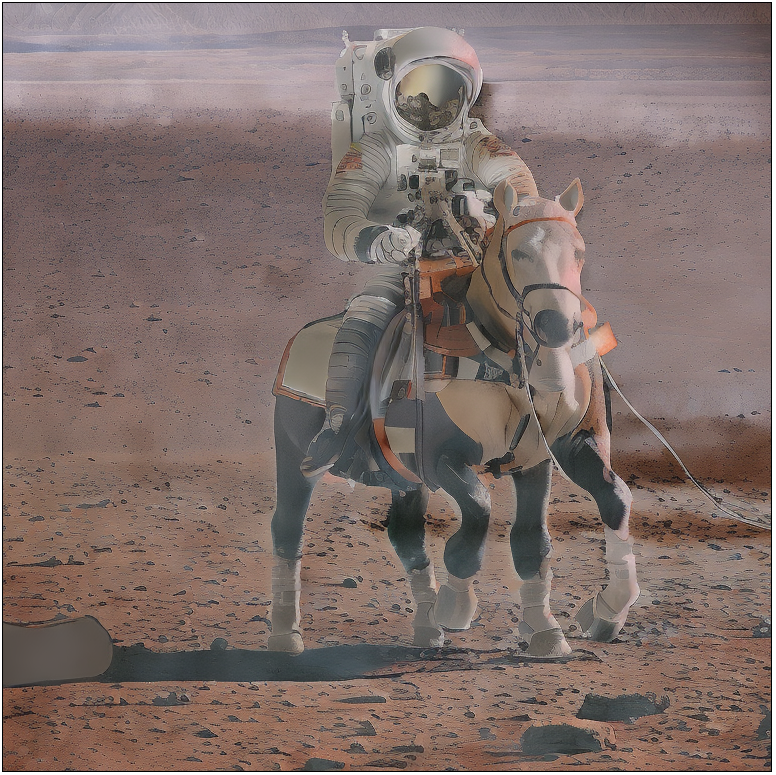

In [9]:
with torch.no_grad():
    latents = 1 / pipe.vae.config.scaling_factor * my_output.detach()
    my_img = pipe.vae.decode(latents, return_dict=False)[0]
    my_img_rescaled = (my_img / 2 + 0.5).clamp(0, 1)

import jhutil; jhutil.jhprint(1111, my_img_rescaled)
my_img_rescaled.rgb

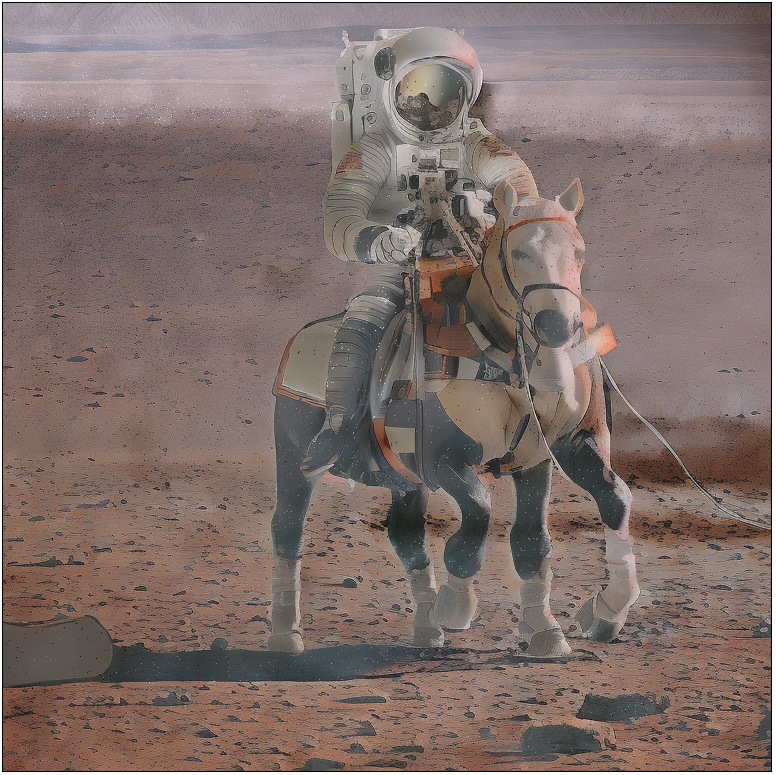

In [10]:
my_img[masked_image != 0] = masked_image[masked_image != 0]
(my_img / 2 + 0.5).clamp(0, 1).rgb